In [2]:
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns # I love this package!
sns.set_style('white')

import torch

### Loss Trend Check

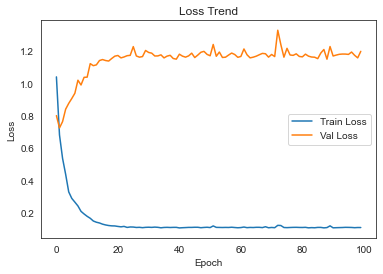

In [9]:
# load check point
model_path = 'checkpoint_EffNetB2_3_adam_0.0001.pth.tar'
checkpoint = torch.load(model_path)
loss_history_train = checkpoint['loss_history_train']
loss_history_val = checkpoint['loss_history_val']

loss_train = [np.mean(torch.stack(l, dim=0).cpu().numpy()) for l in loss_history_train]
loss_val = [np.mean(torch.stack(l, dim=0).cpu().numpy()) for l in loss_history_val]
plt.plot(loss_train, label = 'Train Loss')
plt.plot(loss_val, label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

### Model performance

In [4]:
model_path = 'model_best_EffNetB1_2_finetune_drop25_adam_0.0001.pth.tar'
model = 'EffNetB1'
# calculate outputs for the test data with our best model
output_csv_path = 'predB1.csv'
command = ('python pred.py '
           '--img_dir ./UCLA-protest/img/test '
           '--output_csvpath {csv_path} '
           '--model_dir {model_dir} '
           '--model {model} --batch_size 4 --cuda'
           .format(csv_path = output_csv_path, model_dir = model_path, model = model))

            
!{command}

# load prediction
df_pred = pd.read_csv(output_csv_path)
df_pred['imgpath'] = df_pred['imgpath'].apply(os.path.basename)

# load target
test_label_path = './UCLA-protest/annot_test.txt'
df_target = pd.read_csv(test_label_path, delimiter= '\t')

*** loading model from EffNetB1
*** calculating the model output of the images in ./UCLA-protest/img/test



100%|█████████▉| 8124/8153 [00:34<00:00, 292.49it/s]
8156it [00:34, 235.89it/s]                          


#### Binary Variables

In [5]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
def plot_roc(attr, target, pred):
    """Plot a ROC curve and show the accuracy score and the AUC"""
    fig, ax = plt.subplots()
    auc = roc_auc_score(target, pred)
    acc = accuracy_score(target, (pred >= 0.5).astype(int))
    fpr, tpr, _ = roc_curve(target, pred)
    plt.plot(fpr, tpr, lw = 2, label = attr.title())
    plt.legend(loc = 4, fontsize = 15)
    plt.title(('ROC Curve for {attr} (Accuracy = {acc:.3f}, AUC = {auc:.3f})'
               .format(attr = attr.title(), acc= acc, auc = auc)),
              fontsize = 15)
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.ylabel('True Positive Rate', fontsize = 15)
    plt.show()
    return fig

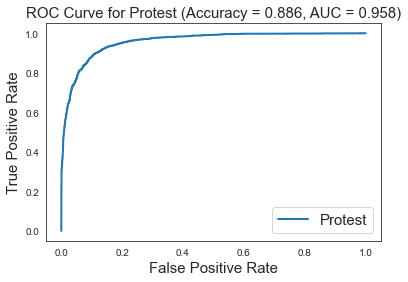

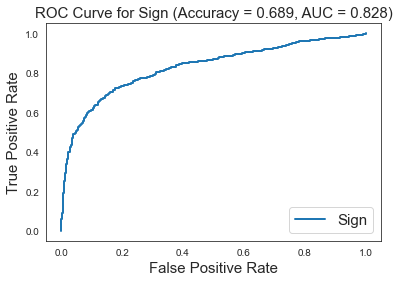

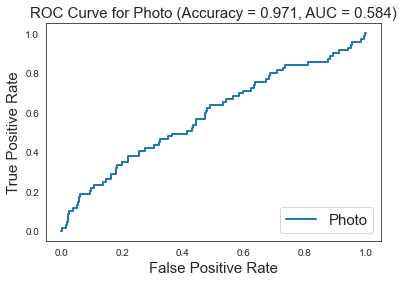

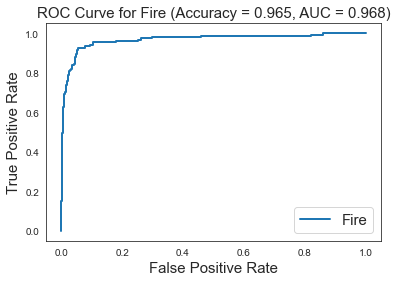

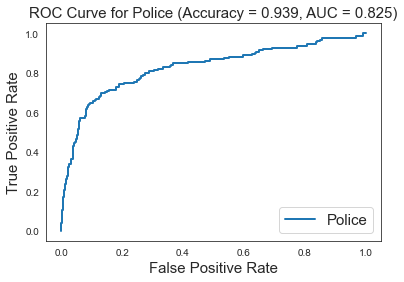

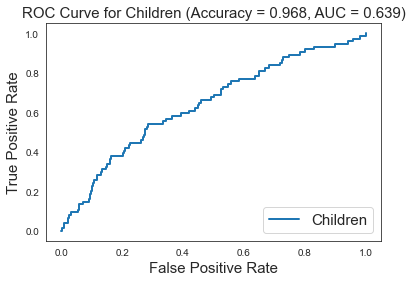

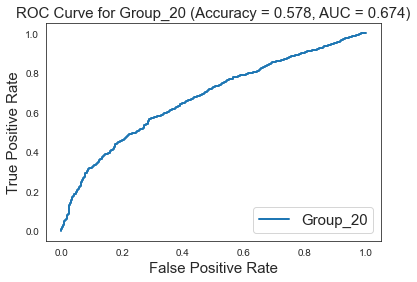

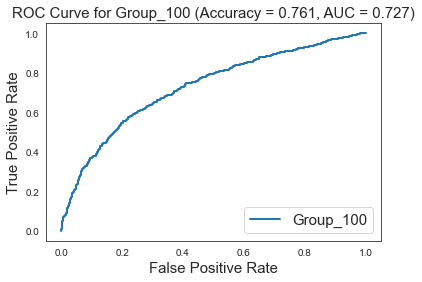

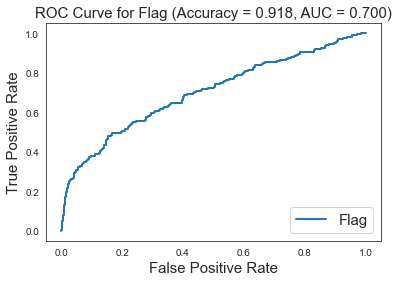

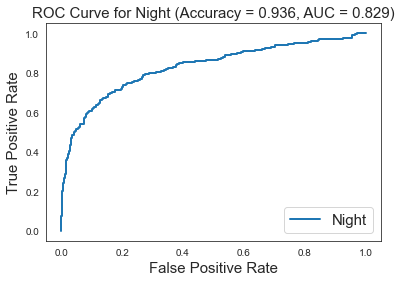

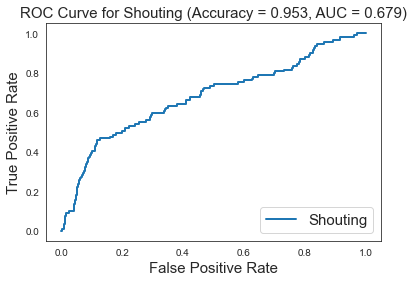

In [6]:
# plot ROC curve for protest
attr = "protest"
target = df_target[attr]
pred = df_pred[attr]
fig = plot_roc(attr, target, pred)
fig.savefig(os.path.join('files', attr+'_EffNetB1_2_drop25_adam_0.0001.png'))
# plot ROC curves for visual attributes
for attr in df_pred.columns[3:]:
    target = df_target[attr]
    pred = df_pred[attr][target != '-']
    target = target[target != '-'].astype(int)
    fig = plot_roc(attr, target, pred)
    fig.savefig(os.path.join('files', attr+'_EffNetB1_2_drop25_adam_0.0001.png'))

#### Violence

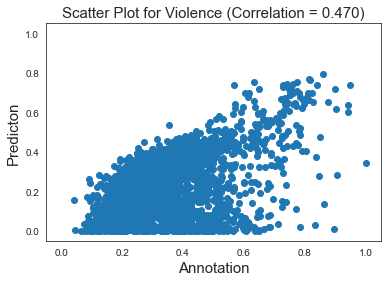

In [6]:
import scipy.stats as stats
attr = 'violence'
pred = df_pred[df_target['protest'] == 1][attr].tolist()
target = df_target[df_target['protest'] == 1][attr].astype(float).tolist()
fig, ax = plt.subplots()
plt.scatter(target, pred, label = attr.title())
plt.xlim([-.05,1.05])
plt.ylim([-.05,1.05])
plt.xlabel('Annotation', fontsize = 15)
plt.ylabel('Predicton', fontsize = 15)
corr, pval = stats.pearsonr(target, pred)
plt.title(('Scatter Plot for {attr} (Correlation = {corr:.3f})'
            .format(attr = attr.title(), corr= corr)), fontsize = 15)
plt.show()
fig.savefig(os.path.join('files', attr+'_EffNetB3_2_drop75_adam_0.0001.png'))

In [32]:
label_frame = pd.read_csv(test_label_path, delimiter="\t").replace('-', 0)
idx = 0
import numpy as np
protest = torch.tensor(label_frame.iloc[idx, 1:2],dtype=torch.float)
violence = torch.tensor(np.asarray(label_frame.iloc[idx, 2:3]).astype('float'),dtype=torch.float)
visattr = torch.tensor(label_frame.iloc[idx, 3:].astype('float'))
label = {'protest':protest, 'violence':violence, 'visattr':visattr}
protest = label_frame.loc[label_frame['protest'] == 1]

print(len(label_frame))
label_frame = pd.read_csv('./UCLA-protest/annot_train.txt', delimiter="\t").replace('-', 0)
protest = label_frame.loc[label_frame['protest'] == 1]
print(len(label_frame))
# print(label_frame.head())
# print(label)
# protest
# violence
# visattr

8153
32611


In [31]:
from PIL import Image
import torchvision.transforms as transforms

path = './UCLA-protest/img/train/train-01092.jpg'
img = Image.open(path)
img = img.convert('RGB')

transform = torch.nn.Sequential(
    
    transforms.RandomResizedCrop((288, 288)),
)

output = transform(img)
output.show()